In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sc
import numpy as np

In [2]:
def MPCdf(x, y, sigmaSq):
    # Marchenko-Pastur cdf for y > 1
    def MPCdfLargeRatio(x, y):
        y1 = 1 - x + y
        temp = np.sqrt(4 * y - y1 * y1)
        y1 /= temp
        y1 = (1 + y) * np.arctan(y1)
        y2 = x * (1 + y)
        y2 -= (y - 1) * (y - 1)
        y2 /= (temp * (y - 1))
        y2 = (y - 1) * np.arctan(y2)
        cdf = np.pi - temp + y1 + y2
        cdf /= (2 * np.pi * y)
        return 1 - cdf

    # Marchenko-Pastur cdf for y <= 1
    def MPCdfSmallRatio(x, y):
        y1 = 1 - x + y
        temp = np.sqrt(4 * y - y1 * y1)
        y1 /= temp
        y1 = (1 + y) * np.arctan(y1)
        if y == 1:
            y2 = 0
        else:
            y2 = x * (1 + y)
            y2 -= (y - 1) * (y - 1)
            y2 /= (temp * (1 - y))
            y2 = (y - 1) * np.arctan(y2)
        cdf = np.pi * y + temp - y1 + y2
        cdf /= (2 * np.pi * y)
        return cdf
    
    x0 = x / sigmaSq
    sqrtY = np.sqrt(y)
    a = (1 - sqrtY) * (1 - sqrtY)
    b = (1 + sqrtY) * (1 + sqrtY)
    if x0 >= b:
        return 1
    if x0 < 0:
        return 0
    if y > 1:
        if x0 <= a:
            return 1 - 1 / y
        return MPCdfLargeRatio(x0, y)
    if x0 <= a:
        return 0
    return MPCdfSmallRatio(x0, y)

In [3]:
# Marchenko-Pastur pdf
def MPPdf(x, y, sigmaSq):
    if x == 0:
        if y > 1:
            return np.inf
        return 0
    sqrtY = np.sqrt(y)
    a = sigmaSq * (1 - sqrtY) * (1 - sqrtY)
    b = sigmaSq * (1 + sqrtY) * (1 + sqrtY)
    if x < a or x > b:
        return 0
    pdf = np.sqrt((b - x) * (x - a))
    pdf /= (y * x)
    pdf /= (2 * np.pi * sigmaSq)
    return pdf

In [4]:
def get_sorted_eigvals(Sigma):
    return np.sort(np.linalg.eigvals(Sigma))


def ESD(x, sorted_eig_values):
    return len(sorted_eig_values[sorted_eig_values <= x]) / len(sorted_eig_values)


def TVARCV(dX, Sigma_RCV):
    (p, n) = dX.shape
    Sigma = np.zeros((p, p))
    minnorm = p
    maxnorm = 0
    for l in range(n):
        dX_l = np.matrix(dX[:, l]).transpose()
        norm = np.linalg.norm(dX_l, ord=2)
        minnorm = min(minnorm, norm * norm)
        maxnorm = max(maxnorm, norm * norm)
        Sigma += dX_l.dot(np.transpose(dX_l)) / (norm * norm)
    Sigma *= np.trace(Sigma_RCV) / n
    #print(minnorm, maxnorm, p / n)
    return Sigma


def RCV(dX):
    (p, n) = dX.shape
    Sigma = np.zeros((p, p))
    for l in range(n):
        dX_l = np.matrix(dX[:, l]).transpose()
        Sigma += dX_l.dot(np.transpose(dX_l))
    return Sigma

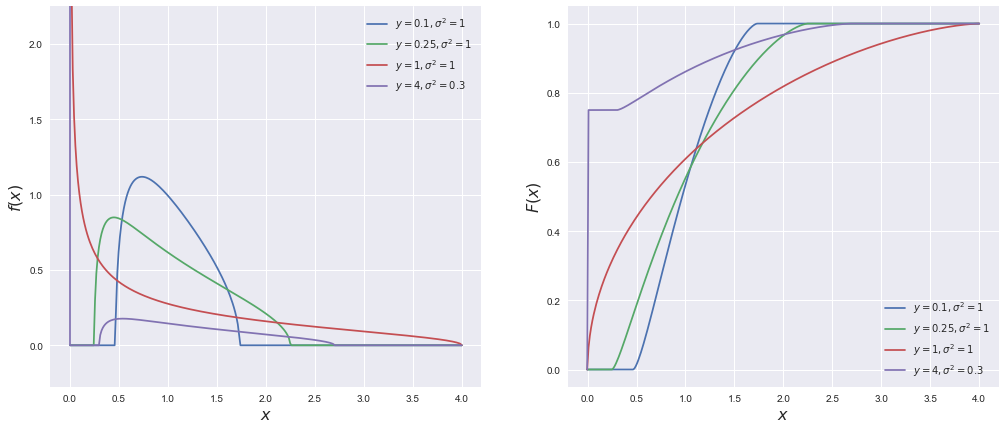

In [5]:
import matplotlib
# notebook settings
matplotlib.rcParams['figure.figsize'] = [17, 7]

y = [0.1, 0.25, 1, 4]
sigma_sq = [1, 1, 1, 0.3]
m = 300
xpdf = np.linspace(1/m, 4, m)
xcdf = np.linspace(-1/m, 4, m)
cdf = np.zeros(m)
pdf = np.zeros(m)

plt.subplot(1, 2, 1)
for ratio, vol in zip(y, sigma_sq):
    for i in range(m):
        pdf[i] = MPPdf(xpdf[i], ratio, vol)
    plt.plot(xpdf, pdf)
plt.ylim(ymax=2.25)
plt.plot((0, 0), (0, 3), color='C3') # plot infinity line for y > 1
plt.legend(["$y=0.1, \sigma^2=1$", "$y=0.25, \sigma^2=1$", "$y=1, \sigma^2=1$", "$y=4, \sigma^2=0.3$"])
plt.xlabel('$x$', fontsize = 16)
plt.ylabel('$f(x)$', fontsize = 16)

plt.subplot(1, 2, 2)
for ratio, vol in zip(y, sigma_sq):
    for i in range(m):
        cdf[i] = MPCdf(xcdf[i], ratio, vol)
    plt.plot(xcdf, cdf)
plt.legend(["$y=0.1, \sigma^2=1$", "$y=0.25, \sigma^2=1$", "$y=1, \sigma^2=1$", "$y=4, \sigma^2=0.3$"]) 
plt.xlabel('$x$', fontsize = 16)
plt.ylabel('$F(x)$', fontsize = 16)

plt.show()

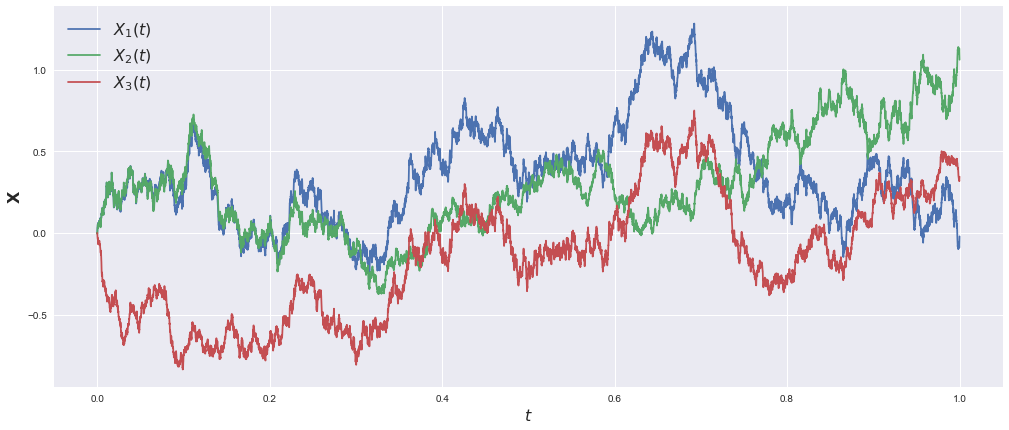

In [6]:
matplotlib.rcParams['figure.figsize'] = [17, 7]

def plot_exmp1():
    n = 10000
    time = np.linspace(0, 1, n)
    mu = np.array([0, 0, 0])
    X = np.zeros((n, 3))
    dt = time[1] - time[0]
    sqrt_dt = np.sqrt(dt)
    dX = np.random.normal(0, sqrt_dt, 3)
    X[1] = X[0] + dX
    for i in range(1, n - 1):
        dW = np.random.normal(0, sqrt_dt, 3)
        Theta = np.identity(3)
        Theta[0][1] = Theta[1][0] = np.cos(np.pi * time[i])
        Theta[0][2] = Theta[2][0] = np.sin(np.pi * time[i])
        dX_l = np.dot(Theta, dW)
        dX_l += mu * dt
        X[i + 1] = X[i] + dX_l
        dX = np.c_[dX, dX_l]

    plt.plot(time, X)
    plt.legend(["$X_1(t)$", "$X_2(t)$", "$X_3(t)$"], fontsize = 16)
    plt.xlabel('$t$', fontsize = 16)
    plt.ylabel('$\mathbf{X}$', fontsize = 16)
    plt.show()
    
plot_exmp1()

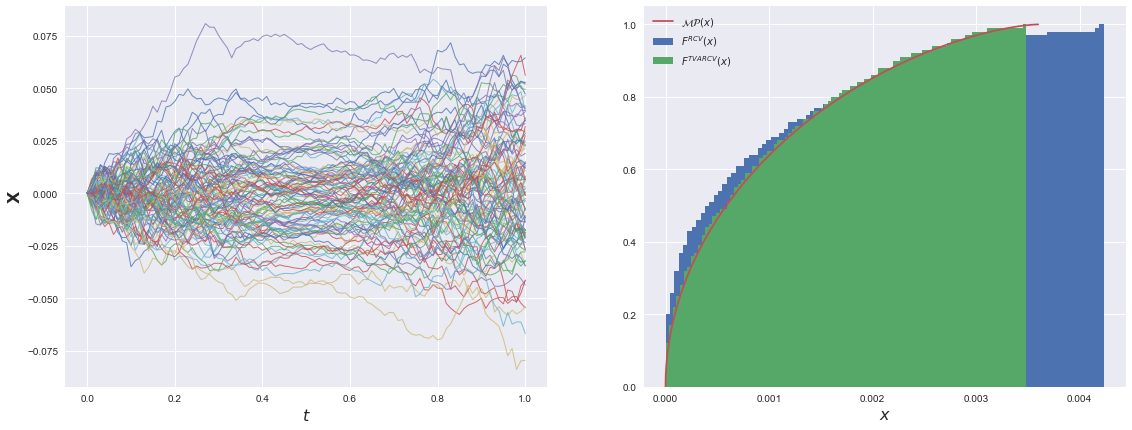

In [7]:
matplotlib.rcParams['figure.figsize'] = [19, 7]

def plot_figures(get_data, n, p):
    X, dX, time, sigma_sq, = get_data(n, p)
    
    plt.subplot(1, 2, 1)
    plt.plot(time, X, alpha=0.8, linewidth=1)
    plt.xlabel('$t$', fontsize = 16)
    plt.ylabel('$\mathbf{X}$', fontsize = 16)    
    
    plt.subplot(1, 2, 2)
    Sigma_RCV = RCV(dX)
    sorted_eigvals_RCV = get_sorted_eigvals(Sigma_RCV)
    plt.hist(sorted_eigvals_RCV, p, cumulative=True, normed=True)
    
    sorted_eigvals_TVARCV = get_sorted_eigvals(TVARCV(dX, Sigma_RCV))
    plt.hist(sorted_eigvals_TVARCV, p, cumulative=True, normed=True)
    
    cdf_len = 3000
    cdf = np.zeros(cdf_len)
    sqrt_ratio = np.sqrt(p / n)
    a = 1 - sqrt_ratio
    b = 1 + sqrt_ratio
    a *= sigma_sq *a
    b *= sigma_sq * b
    x = np.linspace(a, b, cdf_len)
    for i in range(cdf_len):
        cdf[i] = MPCdf(x[i], p / n, sigma_sq)
    plt.plot(x, cdf)
    
    plt.xlabel('$x$', fontsize = 16)
    plt.legend(['$\mathcal{MP}(x)$', \
                '$F^{RCV}(x)$', '$F^{TVARCV}(x)$'])
    plt.show()
    

# function that returns data for Figure 4 and Figure 5
def get_data_for_volatile_gamma(n, p):
    time = np.zeros(n + 1)
    X = np.zeros((n + 1, p))
    delta_time = 1/n
    dX = 0.03 * np.random.normal(0, np.sqrt(delta_time), p)
    X[1] = X[0] + dX
    time[1] += delta_time
    for i in range(1, n):
        delta_time = np.exp(np.mean(X[i, :])) / n
        time[i + 1] = time[i] + delta_time
        dW = np.random.normal(0, np.sqrt(delta_time), p)
        Gamma = 0.0009 + n * 0.0008 * (np.sin(2 * np.pi * (i + 1) / n) - np.sin(2 * np.pi * i / n) ) / (2 * np.pi)
        Gamma = np.sqrt(Gamma)
        dX_l = Gamma * dW
        X[i + 1] = X[i] + dX_l
        dX = np.c_[dX, dX_l]
    return X, dX, time, 0.0009

plot_figures(get_data_for_volatile_gamma, 100, 100)

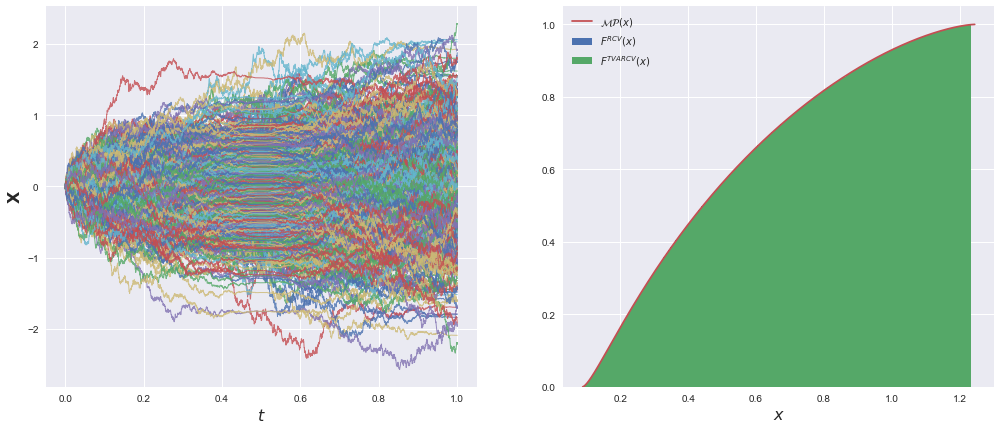

In [43]:
def get_data_for_cossin(n, p):
    time = np.zeros(n + 1)
    X = np.zeros((n + 1, p))
    delta_time = 1/n
    dW = np.random.normal(0, np.sqrt(delta_time), p)
    Theta = np.identity(p)
    for j in range(0, int(p/2)):
        Theta[j][j] = 0
    dX = np.dot(Theta, dW)
    X[1] = X[0] + dX
    time[1] += delta_time
    for i in range(1, n):
        time[i + 1] = time[i] + delta_time
        dW = np.random.normal(0, np.sqrt(delta_time), p)
        nsin = np.sin(np.pi * (i + 1) / n)
        ncos = np.cos(np.pi * (i + 1) / n)
        Theta = np.identity(p) * ncos
        for j in range(0, int(p/2)):
            Theta[j][j] = nsin
        dX_l = np.dot(Theta, dW)
        X[i + 1] = X[i] + dX_l
        dX = np.c_[dX, dX_l]
    return X, dX, time, 0.5

plot_figures(get_data_for_cossin, 3000, 1000)

Data is ready
RCV is ready
TVARCV is ready
Data is ready
RCV is ready
TVARCV is ready


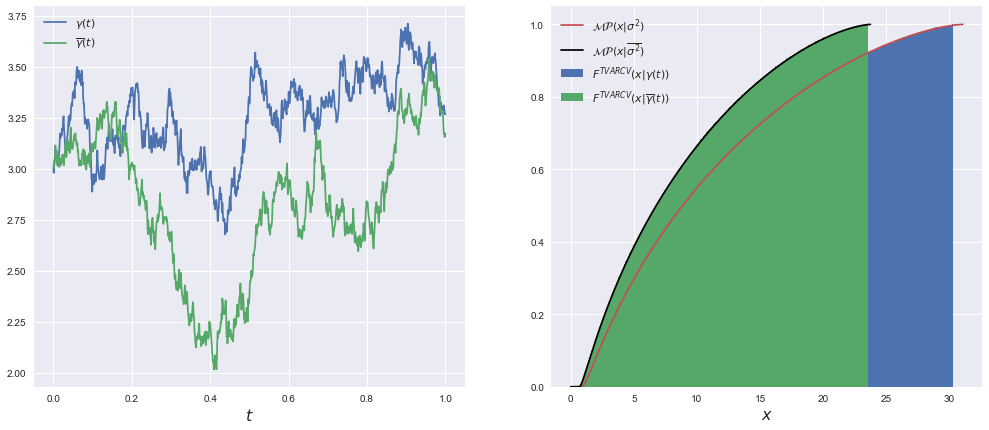

In [9]:
matplotlib.rcParams['figure.figsize'] = [17, 7]

def plot_exmp3(flag):
    n = 1000
    p = 500
    sqrt_p = np.sqrt(p)
    X = np.zeros((n + 1, p))
    time = np.linspace(0, 1, n + 1)
    dt = time[1] - time[0]
    
    alpha = 5
    beta = 1
    xi = 2
    gamma0 = 3
    gamma_sq = gamma0 * gamma0
    gamma = gamma0
    sigma_sq = alpha * alpha * dt
    volatility = gamma0 * np.ones(len(time))
    sqrt_dt = np.sqrt(dt)
    dX = gamma * np.random.normal(0, sqrt_dt, p)
    X[1] = X[0] + dX
    for i in range(1, n):
        dX_l = np.random.normal(0, sqrt_dt, p)
        dW = np.sum(dX_l) / sqrt_p
        dg = beta * (alpha - gamma_sq) * dt + xi * gamma * dW
        gamma_sq += dg
        gamma = np.sqrt(gamma_sq)
        sigma_sq += gamma_sq * dt
        volatility[i] = gamma
        dX_l *= gamma
        X[i + 1] = X[i] + dX_l
        dX = np.c_[dX, dX_l]
        
    volatility[n] = volatility[n - 1]
        
    plt.subplot(1, 2, 1)
    plt.plot(time, volatility)
    plt.xlabel('$t$', fontsize = 16)
    print("Data is ready")
    
    plt.subplot(1, 2, 2)
    Sigma_RCV = RCV(dX)
    #sorted_eigvals_RCV = get_sorted_eigvals(Sigma_RCV)
    #plt.hist(sorted_eigvals_RCV, p, cumulative=True, normed=True)
    print("RCV is ready")
    
    sorted_eigvals_TVARCV = get_sorted_eigvals(TVARCV(dX, Sigma_RCV))
    if flag:
        plt.hist(sorted_eigvals_TVARCV, p, cumulative=True, normed=True)
    else:
        plt.hist(sorted_eigvals_TVARCV, p, cumulative=True, normed=True)
    print("TVARCV is ready")

    cdf_len = 3000
    cdf = np.zeros(cdf_len)
    sqrt_ratio = np.sqrt(p / n)
    a = 1 - sqrt_ratio
    b = 1 + sqrt_ratio
    a *= a
    b *= b
    x = np.linspace(-1/cdf_len, sigma_sq * b, cdf_len)
    for i in range(cdf_len):
        cdf[i] = MPCdf(x[i], p / n, sigma_sq)
    if flag:
        plt.plot(x, cdf, color='C2')
    else:
        plt.plot(x, cdf, color='black')
    
    plt.xlabel('$x$', fontsize = 16)
    
plot_exmp3(1)
plot_exmp3(0)

plt.subplot(1, 2, 1)
plt.legend(['$\gamma(t)$', '$\overline{\gamma}(t)$'], fontsize=11)

plt.subplot(1, 2, 2)
plt.legend(['$\mathcal{MP}(x|\sigma^2)$', '$\mathcal{MP}(x|\overline{\sigma^2})$', '$F^{TVARCV}(x|\gamma(t))$', '$F^{TVARCV}(x|\overline{\gamma}(t))$'], fontsize=11)
plt.show()

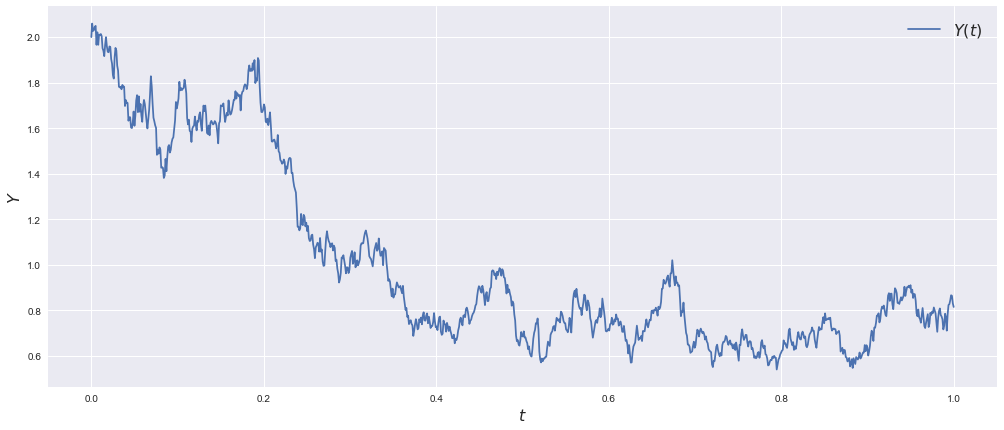

In [10]:
matplotlib.rcParams['figure.figsize'] = [17, 7]

# dX(t) = β(α - X(t))dt + σ(X(t))^(1/2)dB(t)
# CIR(t | α, β, σ, X0) ~ Y / c, where
# Y ~ Noncentral Chi - Squared(4αβ / σ ^ 2, X0 * c * exp(-βt)))
# and c = 4β / (σ ^ 2 * (1.0 - exp(-βt)))
def get_gamma_CIR(t, alpha, beta, sigma, x0):
    dt = t[1] - t[0]
    exp_mbeta_dt = np.exp(-beta * dt)
    c = 4 * beta / (sigma * sigma * (1.0 - exp_mbeta_dt))
    degree = 4 * alpha * beta / (sigma * sigma)
    gamma = x0 * np.ones(len(t))
    sigma_sq = alpha * alpha * dt
    for i in range(1, len(gamma)):
        noncentrality = c * gamma[i - 1] * exp_mbeta_dt
        gamma[i] = np.random.noncentral_chisquare(degree, noncentrality) / c
        sigma_sq += gamma[i] * gamma[i] * dt
    return gamma, sigma_sq

time = np.linspace(0, 1, 1000)
gamma, sigma_sq = get_gamma_CIR(time, 1, 5, 1, 2)
plt.plot(time, gamma)
plt.xlabel('$t$', fontsize = 16)
plt.ylabel('$Y$', fontsize = 16)
plt.legend(['$Y(t)$'], fontsize=16)
plt.show()

Data is ready
RCV is ready
TVARCV is ready


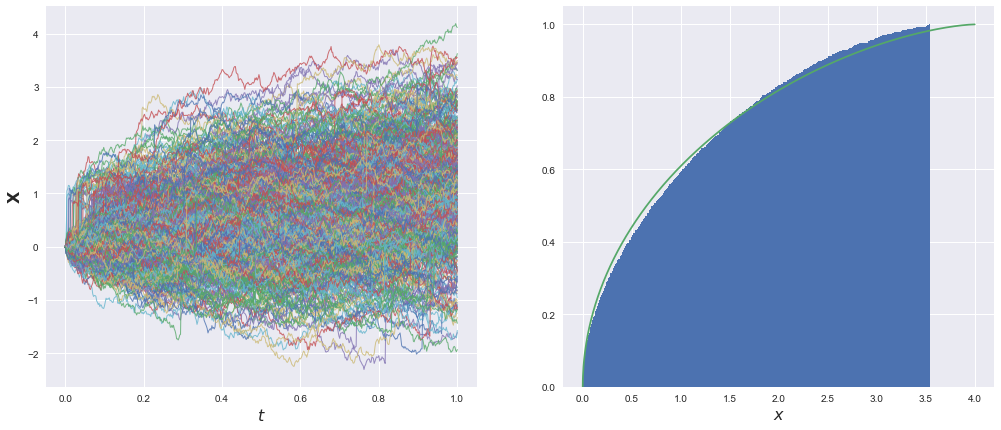

In [11]:
def plot_exmp_jump():
    n = 500
    p = 500
    X = np.zeros((n + 1, p))
    time = np.linspace(0, 1, n + 1)
    dt = time[1] - time[0]
    gamma = 1
    sqrt_dt = np.sqrt(dt)
    dX = gamma * np.random.normal(0, sqrt_dt, p)
    X[1] = X[0] + dX
    U = np.random.randint(n + 2, size=p)
    #U = np.random.randint(n+2)
    for i in range(1, n):
        dX_l = np.random.normal(0, sqrt_dt, p)
        dX_l *= gamma

        #if U == i:
        #    for j in range(p):
        #        dX_l[j] += 1
            
        for j in range(p):
            if U[j] == i:
                dX_l[j] += 1
                
        X[i + 1] = X[i] + dX_l
        dX = np.c_[dX, dX_l]

    plt.subplot(1, 2, 1)
    plt.plot(time, X, alpha=0.8, linewidth=1)
    plt.xlabel('$t$', fontsize = 16)
    plt.ylabel('$\mathbf{X}$', fontsize = 16)    
    print("Data is ready")
    
    plt.subplot(1, 2, 2)
    Sigma_RCV = RCV(dX) - np.identity(p)
    #sorted_eigvals_RCV = get_sorted_eigvals(Sigma_RCV)
    #plt.hist(sorted_eigvals_RCV, p, cumulative=True, normed=True)
    print("RCV is ready")
    
    sorted_eigvals_TVARCV = get_sorted_eigvals(TVARCV(dX, Sigma_RCV))
    plt.hist(sorted_eigvals_TVARCV, p, cumulative=True, normed=True)
    print("TVARCV is ready")
    
    sigma_sq = 1
    cdf_len = 3000
    cdf = np.zeros(cdf_len)
    sqrt_ratio = np.sqrt(p / n)
    a = 1 - sqrt_ratio
    b = 1 + sqrt_ratio
    a *= a
    b *= b
    x = np.linspace(-1/cdf_len, sigma_sq * b, cdf_len)
    for i in range(cdf_len):
        cdf[i] = MPCdf(x[i], p / n, sigma_sq)
    plt.plot(x, cdf)
    
    plt.xlabel('$x$', fontsize = 16)
    
plot_exmp_jump()
plt.show()

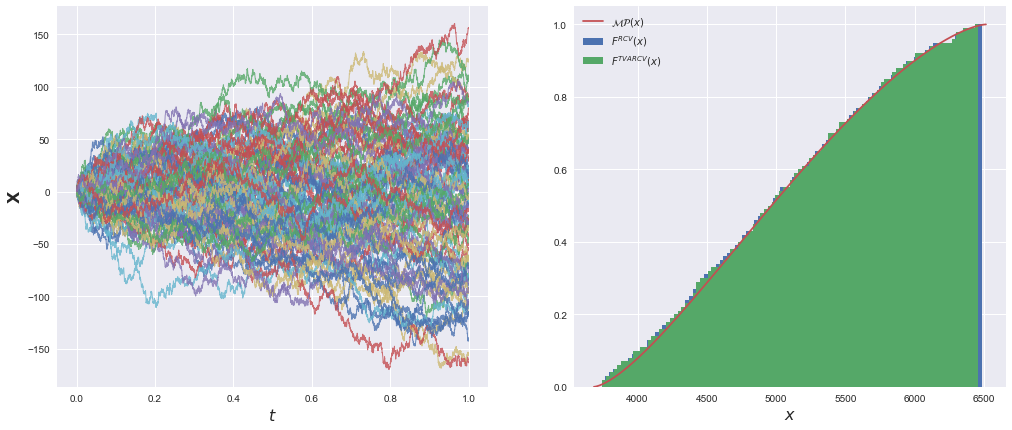

In [12]:
def get_data_jumps(n, p):
    X = np.zeros((n + 1, p))
    time = np.linspace(0, 1, n + 1)
    dt = time[1] - time[0]
    gamma = 1
    sqrt_dt = np.sqrt(dt)
    dX = gamma * np.random.normal(0, sqrt_dt, p)
    X[1] = X[0] + dX
    rate = 10000
    jump_time = np.random.exponential(1 / rate, p)
    for i in range(1, n):
        dX_l = np.random.normal(0, sqrt_dt, p)
        dX_l *= gamma
        for j in range(p):
            if jump_time[j] <= i / n:
                dX_l[j] += np.random.normal(0, 1)
                jump_time[j] += np.random.exponential(1 / rate)
        X[i + 1] = X[i] + dX_l
        dX = np.c_[dX, dX_l]
    return X, dX, time, n

plot_figures(get_data_jumps, 5000, 100)

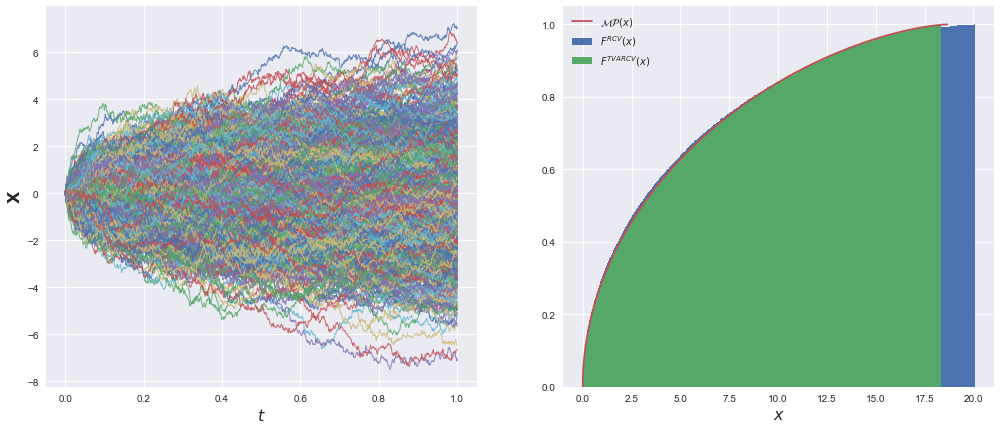

In [13]:
def get_data_stochastic_gamma(n, p):
    sqrt_p = np.sqrt(p)
    X = np.zeros((n + 1, p))
    time = np.linspace(0, 1, n + 1)
    dt = time[1] - time[0]
    alpha = 5
    beta = 1
    xi = 2
    gamma0 = 3
    gamma_sq = gamma0 * gamma0
    gamma = gamma0
    sigma_sq = alpha * alpha * dt
    volatility = gamma0 * np.ones(len(time))
    sqrt_dt = np.sqrt(dt)
    dX = gamma * np.random.normal(0, sqrt_dt, p)
    X[1] = X[0] + dX
    for i in range(1, n):
        dX_l = np.random.normal(0, sqrt_dt, p)
        dW = np.sum(dX_l) / sqrt_p
        dg = beta * (alpha - gamma_sq) * dt + xi * gamma * dW
        gamma_sq += dg
        gamma = np.sqrt(gamma_sq)
        sigma_sq += gamma_sq * dt
        volatility[i] = gamma
        dX_l *= gamma
        X[i + 1] = X[i] + dX_l
        dX = np.c_[dX, dX_l]
    return X, dX, time, sigma_sq


plot_figures(get_data_stochastic_gamma, 1000, 1000)

0.994996355534


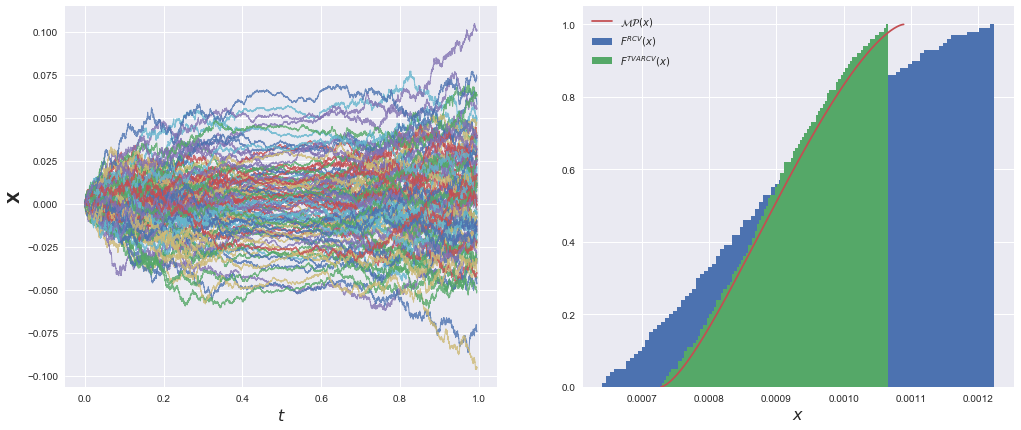

In [32]:
def get_data_poisson_times(n, p):
    time = np.zeros(n + 1)
    X = np.zeros((n + 1, p))
    rate = 1 / n
    delta_time = np.random.exponential(rate)
    dX = 0.03 * np.random.normal(0, np.sqrt(delta_time), p)
    X[1] = X[0] + dX
    time[1] += delta_time
    for i in range(1, n):
        delta_time = np.random.exponential(rate)
        time[i + 1] = min(time[i] + delta_time, 1)
        dW = np.random.normal(0, np.sqrt(delta_time), p)
        Gamma = 0.0009 + 0.0008 * (np.sin(2 * np.pi * time[i+1]) - np.sin(2 * np.pi * time[i])) / (2 * np.pi * delta_time)
        Gamma = np.sqrt(Gamma)
        dX_l = Gamma * dW
        X[i + 1] = X[i] + dX_l
        dX = np.c_[dX, dX_l]
    return X, dX, time, 0.0009


plot_figures(get_data_poisson_times, 10000, 100)